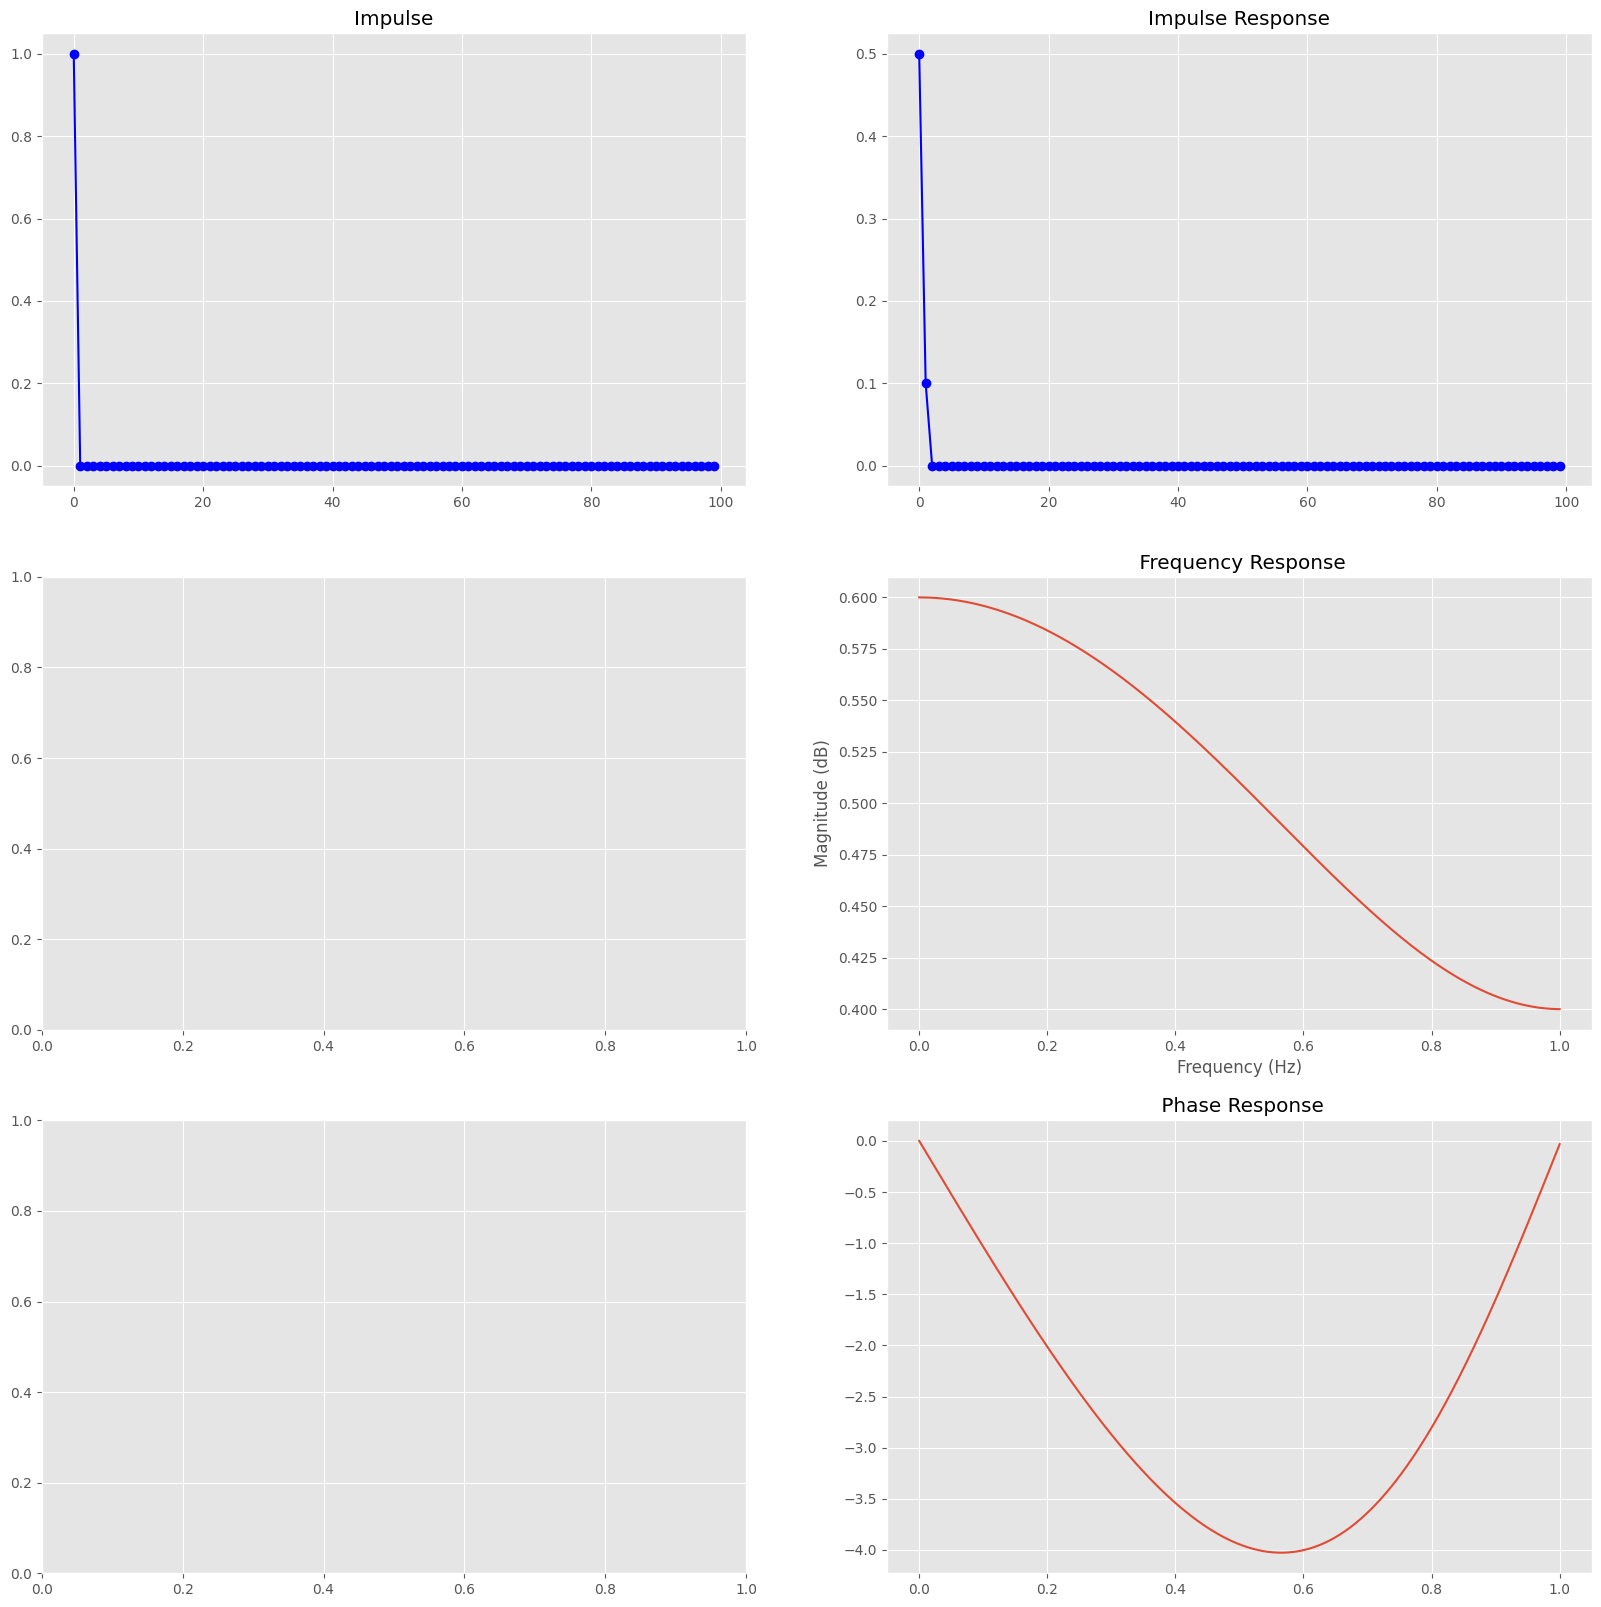

In [77]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from matplotlib import style 

plt.style.use('ggplot')



def plot(impulse, response):
    x=np.linspace(0, 1, response.size//2)
    
    
    #with np.errstate(divide='ignore', invalid='ignore'):
    if True:
        response_fft = fft.fft(response)
        #y=(20 * np.log10(np.abs(response_fft)))[:response_fft.size//2]
        y=((np.abs(response_fft)))[:response_fft.size//2]
        phase=(20 * np.angle(response_fft))[:response_fft.size//2]
        

    fig, ax = plt.subplots(3,2, figsize=(20, 20))

    ax[0][0].plot(impulse[:100],'bo-')
    ax[0][0].set_title('Impulse')
    ax[0][1].plot(response[:100],'bo-')
    ax[0][1].set_title('Impulse Response')

    ax[1][1].plot(x, y, label='b')
    ax[1][1].set_xlabel('Frequency (Hz)')
    ax[1][1].set_ylabel('Magnitude (dB)')
    ax[1][1].set_title(' Frequency Response')

    ax[2][1].plot(x, phase, label='b')
    ax[2][1].set_title(' Phase Response')

samples=1000

impulse = np.zeros(samples)
impulse[0] = 1

def feedForward(x, a0, a1):
    b = np.zeros(samples)
    for i in range(0, x.size):
        b[i] = a0 * x[i] + a1 * x[i-1]
    return b

response = feedForward(impulse,0.5, 0.5);
#

impulse = np.zeros(samples)
impulse[0] = 1

def sinc(x):
    b = np.zeros(samples)
    b[0] = 1
    for i in range(1, x.size):
        b[i] = np.sin(i)/(i)
    return b

def tent(x,a0,a1,a2):
    b = np.zeros(samples)
    for i in range(0, x.size-1):
        b[i] = a0* x[i-1] + a1 * x[i] + a2*x[i+1]
    return b


response = tent(impulse,0.10, 0.5, 0.10)
plot(impulse, response)


